In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

%matplotlib inline

#### Loading data created by psql and some exploration

In [43]:
df = pd.read_csv('data/bowling_data_enhanced.csv')
df.shape

(4742, 30)

In [44]:
df.head()

,overs,mdns,runs,wkts,econ,ave,strike_rate,opposition,ground,home_away,...,year5_mtchs_pld,year1_wkts_pm,year2_wkts_pm,year3_wkts_pm,year4_wkts_pm,year5_wkts_pm,bowler_agnst_oppo,oppo_agnst_bowl_typ,bowl_home_adv,ground_bowl_typ
0,32.0,6,105,6,3.28,17.50,32.0,West Indies,Manchester,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34.0,5,108,4,3.17,27.00,51.0,New Zealand,Nottingham,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,4,25,3,2.50,8.33,20.0,West Indies,Lord's,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,37.5,12,103,3,2.72,34.33,75.6,New Zealand,Lord's,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.0,1,52,2,3.46,26.00,45.0,West Indies,Birmingham,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df.columns

Index(['overs', 'mdns', 'runs', 'wkts', 'econ', 'ave', 'strike_rate',
       'opposition', 'ground', 'home_away', 'bowling_arm', 'pace_spin',
       'player', 'country', 'year', 'balls', 'year1_mtchs_pld',
       'year2_mtchs_pld', 'year3_mtchs_pld', 'year4_mtchs_pld',
       'year5_mtchs_pld', 'year1_wkts_pm', 'year2_wkts_pm', 'year3_wkts_pm',
       'year4_wkts_pm', 'year5_wkts_pm', 'bowler_agnst_oppo',
       'oppo_agnst_bowl_typ', 'bowl_home_adv', 'ground_bowl_typ'],
      dtype='object')

In [46]:
mask_2005_2011 = (df.year >= 2005) & (df.year <= 2011)

In [47]:
mask_2005_2011.value_counts()

False    2966
True     1776
Name: year, dtype: int64

In [49]:
len(mask_2005_2011), type(mask_2005_2011)

(4742, pandas.core.series.Series)

In [50]:
df_2005_2011 = df[mask_2005_2011]
df_2005_2011.shape

(1776, 30)

In [51]:
df_2005_2011_small = df_2005_2011[['wkts','year1_mtchs_pld',
       'year1_wkts_pm', 'bowler_agnst_oppo',
       'oppo_agnst_bowl_typ', 'bowl_home_adv', 'ground_bowl_typ']]

In [52]:
df_2005_2011_small.head(20)

,wkts,year1_mtchs_pld,year1_wkts_pm,bowler_agnst_oppo,oppo_agnst_bowl_typ,bowl_home_adv,ground_bowl_typ
273,0,4.0,1.250000,1.000000,1.477124,0.375000,1.309524
274,2,3.0,2.000000,1.003472,1.159041,0.521739,1.309524
275,7,10.0,5.800000,1.000000,1.159041,0.407855,1.309524
276,3,8.0,2.250000,1.000000,0.840114,0.282051,0.864583
277,1,2.0,0.500000,1.000000,0.840114,0.500000,0.864583
278,6,4.0,4.000000,1.000000,0.840114,0.500000,0.864583
279,1,0.0,0.000000,1.000000,0.840114,0.500000,0.864583
280,2,8.0,1.000000,1.000000,0.840114,0.418605,0.864583
281,7,1.0,4.000000,1.209877,0.967320,0.564815,0.864583
282,3,8.0,3.750000,0.697674,0.967320,0.476744,0.864583


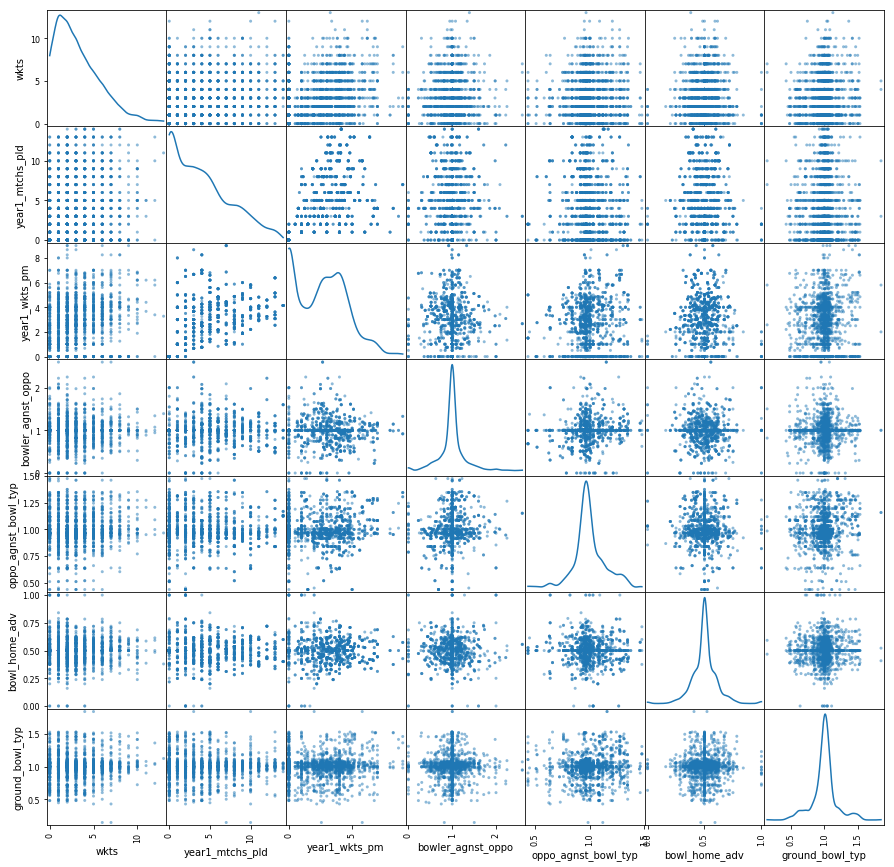

In [53]:
scatter_matrix(df_2005_2011_small, figsize=(15,15), diagonal='kde')
plt.show()

#### Training with 2005-2010 data and testing on 2011

In [54]:
features = ['year1_mtchs_pld',
       'year2_mtchs_pld', 'year3_mtchs_pld', 'year4_mtchs_pld',
       'year5_mtchs_pld', 'year1_wkts_pm', 'year2_wkts_pm', 'year3_wkts_pm',
       'year4_wkts_pm', 'year5_wkts_pm', 'bowler_agnst_oppo',
       'oppo_agnst_bowl_typ', 'bowl_home_adv', 'ground_bowl_typ']
target = 'wkts'

In [55]:
mask_2005_2010 = (df.year >= 2005) & (df.year <= 2010)
mask_2011 = (df.year == 2011)

In [56]:
len(mask_2005_2010), type(mask_2005_2010), len(mask_2011), type(mask_2011)

(4742, pandas.core.series.Series, 4742, pandas.core.series.Series)

In [57]:
mask_2005_2010.value_counts()

False    3185
True     1557
Name: year, dtype: int64

In [60]:
X_train = df[mask_2005_2010][features]
X_test = df[mask_2011][features]
y_train = df[mask_2005_2010][target]
y_test = df[mask_2011][target]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1557, 14), (219, 14), (1557,), (219,))

In [70]:
rf = RandomForestRegressor(n_estimators=100,max_features=5,n_jobs=-1,random_state=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [71]:
print("R^2 Score: ", rf.score(X_test, y_test))

R^2 Score:  -0.0837703679769


In [65]:
feature_importance = {}
for label, importance in zip(X_train.columns, rf.feature_importances_):
    feature_importance[label] = importance

#feature_importance
sorted(feature_importance.items(), key=lambda x: (-x[1]))

[('ground_bowl_typ', 0.31987757109102249),
 ('oppo_agnst_bowl_typ', 0.14528584703308775),
 ('year1_wkts_pm', 0.10026538901589331),
 ('bowl_home_adv', 0.067027140329687332),
 ('bowler_agnst_oppo', 0.059101650292704713),
 ('year3_wkts_pm', 0.053127243171482832),
 ('year2_wkts_pm', 0.049040735443305242),
 ('year4_wkts_pm', 0.044540844331590786),
 ('year1_mtchs_pld', 0.041003218081099461),
 ('year2_mtchs_pld', 0.02873168296544331),
 ('year5_wkts_pm', 0.026965273373650307),
 ('year4_mtchs_pld', 0.02226124689010886),
 ('year3_mtchs_pld', 0.021872778352886247),
 ('year5_mtchs_pld', 0.020899379628037382)]

[ 0.31987757  0.14528585  0.10026539  0.06702714  0.05910165  0.05312724
  0.04904074  0.04454084  0.04100322  0.02873168  0.02696527  0.02226125
  0.02187278  0.02089938]


(-1, 14)

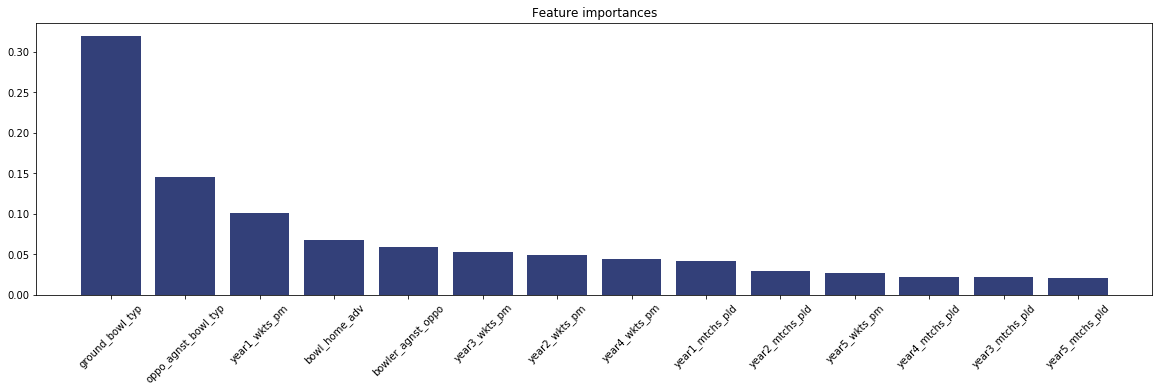

In [80]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train.columns[indices])
print (importances[indices])
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(14), importances[indices], color="#334079", align="center")
# #664079
plt.xticks(range(14), feature_names,rotation='45')
plt.xlim([-1, 14])

In [83]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', 5, None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100,300,500],
                      'random_state': [10]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='r2')
rf_gridsearch.fit(X_train, y_train)

print("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 470 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 820 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.7min finished


best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 10}


In [84]:
rf_gridsearch.best_score_

0.067828001630825738

In [88]:
rf_gridsearch.score(X_test,y_test)

-0.022167316162469586

In [89]:
best_rf_model.score(X_test,y_test)

-0.022167316162469586

In [91]:
feature_importance = {}
for label, importance in zip(X_train.columns, best_rf_model.feature_importances_):
    feature_importance[label] = importance

#feature_importance
sorted(feature_importance.items(), key=lambda x: (-x[1]))

[('year1_wkts_pm', 0.3449863591221019),
 ('year4_wkts_pm', 0.17194511058217363),
 ('year3_wkts_pm', 0.13783850464054984),
 ('year2_wkts_pm', 0.10211723260571721),
 ('ground_bowl_typ', 0.038404915486087654),
 ('year5_wkts_pm', 0.037840587479928259),
 ('year1_mtchs_pld', 0.037623923665338982),
 ('bowl_home_adv', 0.026068425551716692),
 ('oppo_agnst_bowl_typ', 0.022754612060818347),
 ('bowler_agnst_oppo', 0.020974925564761975),
 ('year5_mtchs_pld', 0.020754004140177675),
 ('year4_mtchs_pld', 0.015433864635704403),
 ('year2_mtchs_pld', 0.012056425299555092),
 ('year3_mtchs_pld', 0.01120110916536831)]

[ 0.34498636  0.17194511  0.1378385   0.10211723  0.03840492  0.03784059
  0.03762392  0.02606843  0.02275461  0.02097493  0.020754    0.01543386
  0.01205643  0.01120111]


(-1, 14)

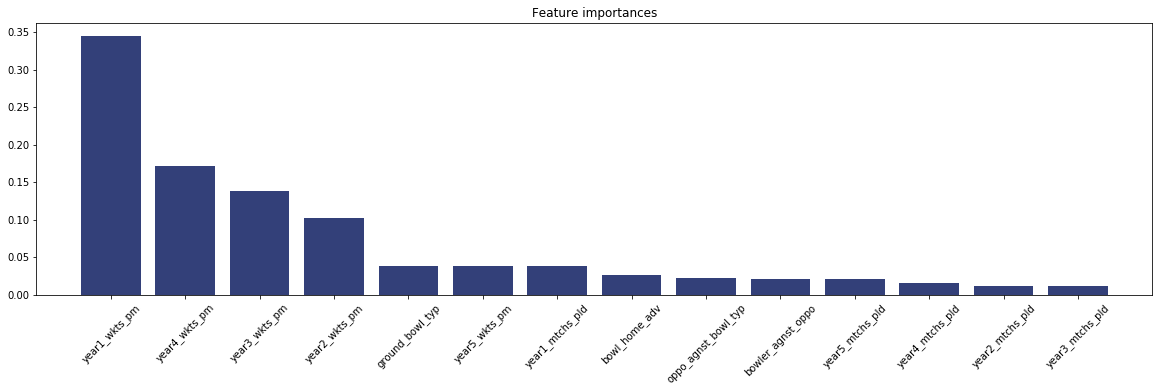

In [93]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train.columns[indices])
print (importances[indices])
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(14), importances[indices], color="#334079", align="center")
# #664079
plt.xticks(range(14), feature_names,rotation='45')
plt.xlim([-1, 14])

In [99]:
features_small = ['year1_wkts_pm','year2_wkts_pm', 'year3_wkts_pm', 'year4_wkts_pm','year5_wkts_pm',
                  'bowler_agnst_oppo','oppo_agnst_bowl_typ', 'bowl_home_adv', 'ground_bowl_typ']

In [100]:
X_train = df[mask_2005_2010][features_small]
X_test = df[mask_2011][features_small]
y_train = df[mask_2005_2010][target]
y_test = df[mask_2011][target]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1557, 9), (219, 9), (1557,), (219,))

In [101]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', 5, None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100,300,500],
                      'random_state': [10]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='r2')
rf_gridsearch.fit(X_train, y_train)

print("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:  3.2min


best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 10}


[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.6min finished


In [102]:
best_rf_model.score(X_test,y_test)

-0.013513787519671361

In [103]:
feature_importance = {}
for label, importance in zip(X_train.columns, best_rf_model.feature_importances_):
    feature_importance[label] = importance

#feature_importance
sorted(feature_importance.items(), key=lambda x: (-x[1]))

[('year1_wkts_pm', 0.3444853946521062),
 ('year3_wkts_pm', 0.18777579843916481),
 ('year4_wkts_pm', 0.14066801912776553),
 ('year2_wkts_pm', 0.11880049070459016),
 ('year5_wkts_pm', 0.083527226643849872),
 ('bowl_home_adv', 0.04071466478471631),
 ('ground_bowl_typ', 0.038715865208038838),
 ('oppo_agnst_bowl_typ', 0.024243361056361303),
 ('bowler_agnst_oppo', 0.02106917938340705)]

[ 0.34448539  0.1877758   0.14066802  0.11880049  0.08352723  0.04071466
  0.03871587  0.02424336  0.02106918]


(-1, 10)

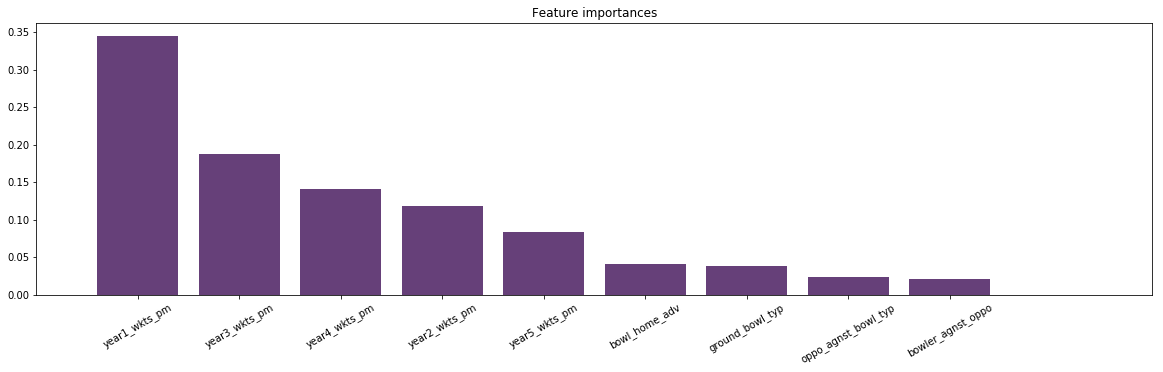

In [107]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train.columns[indices])
print (importances[indices])
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(9), importances[indices], color="#664079", align="center")
# #664079
plt.xticks(range(9), feature_names,rotation='30')
plt.xlim([-1, 10])